In [ ]:
'''
File 8 of 8 of kdd pipeline

Key features: investigating features and building a model for: total_magnetization
'''

In [2]:
import pandas as pd

numerical_df = pd.read_csv("../dataset/cleaned_numerical_data.csv")
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155361 entries, 0 to 155360
Data columns (total 45 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   nsites                                        155361 non-null  int64  
 1   nelements                                     155361 non-null  int64  
 2   volume                                        155361 non-null  float64
 3   density                                       155361 non-null  float64
 4   density_atomic                                155361 non-null  float64
 5   deprecated                                    155361 non-null  int64  
 6   energy_per_atom                               152149 non-null  float64
 7   formation_energy_per_atom                     152149 non-null  float64
 8   energy_above_hull                             152149 non-null  float64
 9   is_stable                                     15

In [3]:
#split data into real and theoretical subsets model on real values first

numerical_df.drop(['deprecated'], axis=1, inplace=True)

real_df = numerical_df[numerical_df['theoretical'] == 0].copy()
theoretical_df = numerical_df[numerical_df['theoretical'] == 1].copy()

real_df.drop(['theoretical'], axis=1, inplace=True)
theoretical_df.drop(['theoretical'], axis=1, inplace=True)

print("Real df shape:", real_df.shape)
print("Theoretical df shape:", theoretical_df.shape)

Real df shape: (49772, 43)
Theoretical df shape: (105589, 43)


In [4]:
real_df['total_magnetization'].describe()
#Note, total_magnetization is not normally distributed and is skewed right

count    4.958000e+04
mean     3.841016e+00
std      1.108420e+01
min      0.000000e+00
25%      2.000000e-07
50%      1.067050e-03
75%      2.156984e+00
max      3.200437e+02
Name: total_magnetization, dtype: float64

In [5]:
'''
Option for dealing with null values for target value use median value because data is skewed
'''
print(theoretical_df['total_magnetization'].isna().sum())
print(real_df['total_magnetization'].isna().sum())

real_df['total_magnetization'] = real_df['total_magnetization'].fillna(real_df['total_magnetization'].median())
theoretical_df['total_magnetization'] = theoretical_df['total_magnetization'].fillna(real_df['total_magnetization'].median())

print(real_df['total_magnetization'].isna().sum())
print(theoretical_df['total_magnetization'].isna().sum())


790
192
0
0


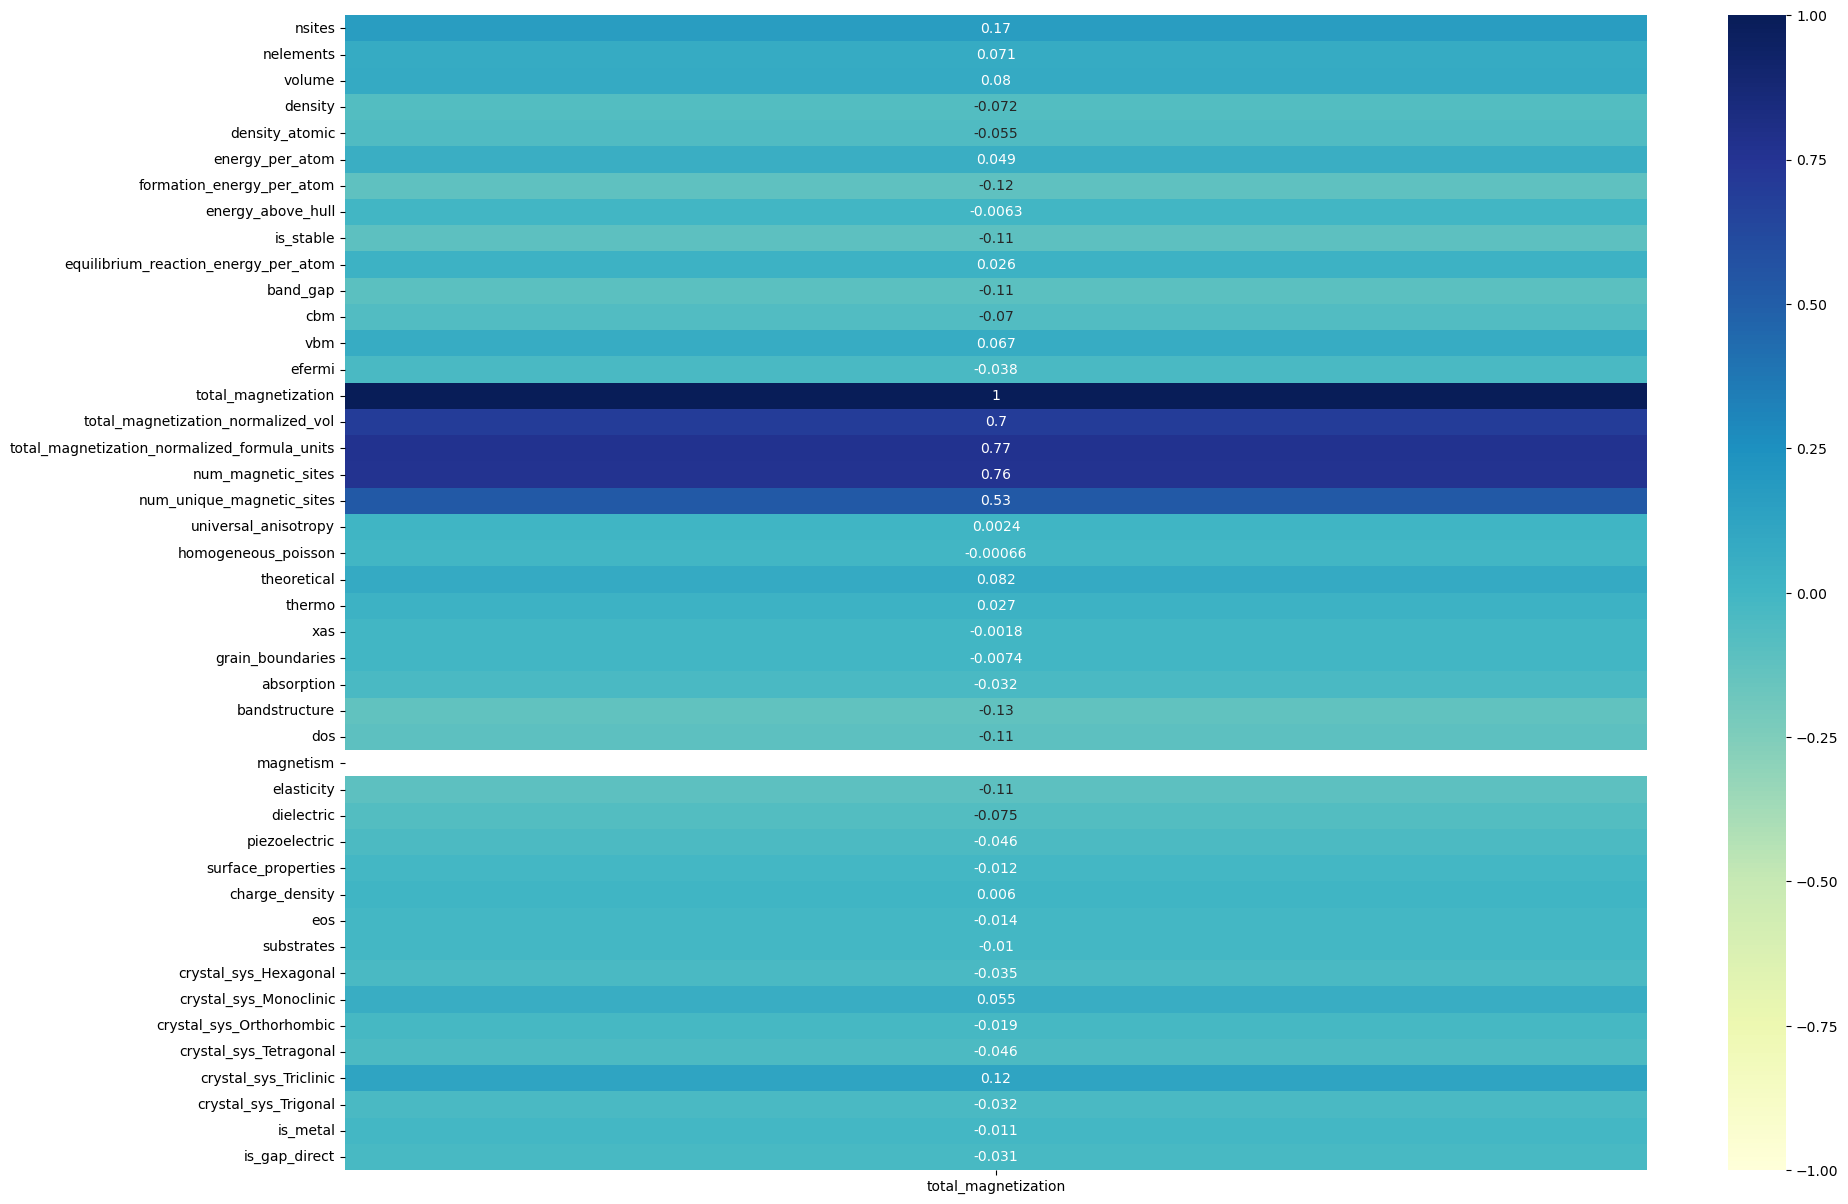

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(21, 15))
corr_matrix = numerical_df.corr()

corr_band_gap = corr_matrix[['total_magnetization']]
sns.heatmap(corr_band_gap, annot=True, cmap="YlGnBu", vmin=-1, vmax=1)

plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Create the list of features to train with below
feature_names = [ "elasticity", "is_stable","nsites", "formation_energy_per_atom",
 "total_magnetization_normalized_formula_units","num_magnetic_sites","num_unique_magnetic_sites" ]

X = real_df[feature_names]
X = X.fillna(X.median(numeric_only=True))
y = real_df["total_magnetization"]

In [8]:
train_X, test_x, train_y, test_y = train_test_split(X, y, train_size = 0.2, random_state=1)

#Get train, test and theoretical sets:
theoretical_df = theoretical_df.dropna(subset=['total_magnetization'])
theoretical_x = theoretical_df[feature_names]
theoretical_x = theoretical_x.fillna(X.median(numeric_only=True))

theoretical_y = theoretical_df['total_magnetization']

In [9]:
from sklearn.tree import DecisionTreeRegressor

dtr_model = DecisionTreeRegressor(    
    max_depth=15,#Best performance on theoretical set with 15
    min_samples_split=20, #Best performance on theoretical set with 50
    min_samples_leaf=10,#Best performance on theoretical set with 10
    max_features='sqrt',
    criterion='squared_error',
)
dtr_model.fit(train_X, train_y)

DecisionTreeRegressor(max_depth=15, max_features='sqrt', min_samples_leaf=10,
                      min_samples_split=20)

In [10]:
#Tree Model on Train, Test and Theoretical Sets

from sklearn.metrics import r2_score, root_mean_squared_error

# Predict on Train Set
train_predictions = dtr_model.predict(train_X)
train_r2 = r2_score(train_y, train_predictions)
train_rmse = root_mean_squared_error(train_y, train_predictions)
train_relative_rmse = train_rmse / train_y.mean()

# Predict on Test Set
test_predictions = dtr_model.predict(test_x)
test_r2 = r2_score(test_y, test_predictions)
test_rmse = root_mean_squared_error(test_y, test_predictions)
test_relative_rmse = test_rmse / test_y.mean()

#predict on theoretical data
theoretical_predictions = dtr_model.predict(theoretical_x)
theoretical_r2 = r2_score(theoretical_y, theoretical_predictions)
theoretical_rmse = root_mean_squared_error(theoretical_y, theoretical_predictions)
theoretical_relative_rmse = theoretical_rmse / theoretical_y.mean()

# Create a DataFrame for the tree metrics
tree_metrics = {
    'Dataset': ['Train Set', 'Test Set', 'Theoretical Set'],
    'R-squared': [f"{train_r2:.3f}", f"{test_r2:.3f}", f"{theoretical_r2:.3f}"],
    'Root Mean Squared Error': [f"{train_rmse:.3f}", f"{test_rmse:.3f}", f"{theoretical_rmse:.3f}"],
    'Relative RMSE': [f"{train_relative_rmse:.3f}", f"{test_relative_rmse:.3f}", f"{theoretical_relative_rmse:.3f}"]
}
df_tree_metrics = pd.DataFrame(tree_metrics)
print(df_tree_metrics)
df_tree_metrics.to_csv('../performance_metrics/total_magnetization_tree.csv', index=False)

           Dataset R-squared Root Mean Squared Error Relative RMSE
0        Train Set     0.826                   4.663         1.236
1         Test Set     0.724                   5.798         1.510
2  Theoretical Set     0.669                   7.327         1.228


In [11]:
from sklearn.ensemble import RandomForestRegressor

# Fitting Random Forest Regression to the dataset
rfr = RandomForestRegressor(
    oob_score=True,
    max_depth=200 ,#Best performance on theoretical set with 200
    min_samples_split=20, #Best performance on theoretical set with 50
    min_samples_leaf=10,#Best performance on theoretical set with 10
    max_features='sqrt',
    criterion='squared_error',
    n_estimators=200 #best performed with 20
)

rfr.fit(train_X, train_y)

RandomForestRegressor(max_depth=200, max_features='sqrt', min_samples_leaf=10,
                      min_samples_split=20, n_estimators=200, oob_score=True)

In [16]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Fitting SVR to the dataset
svr = SVR(kernel='rbf', C=100, epsilon=0.01)

svr.fit(train_X, train_y)

# Predict on Train Set
train_predictions = svr.predict(train_X)
train_r2 = r2_score(train_y, train_predictions)
train_rmse = np.sqrt(mean_squared_error(train_y, train_predictions))
train_relative_rmse = train_rmse / train_y.mean()

# Predict on Test Set
test_predictions = svr.predict(test_x)
test_r2 = r2_score(test_y, test_predictions)
test_rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
test_relative_rmse = test_rmse / test_y.mean()

# Predict on Theoretical Set
theoretical_predictions = svr.predict(theoretical_x)
theoretical_r2 = r2_score(theoretical_y, theoretical_predictions)
theoretical_rmse = np.sqrt(mean_squared_error(theoretical_y, theoretical_predictions))
theoretical_relative_rmse = theoretical_rmse / theoretical_y.mean()

# Create a DataFrame for the metrics
svr_metrics = {
    'Dataset': ['Train Set', 'Test Set', 'Theoretical Set'],
    'R-squared': [f"{train_r2:.3f}", f"{test_r2:.3f}", f"{theoretical_r2:.3f}"],
    'Root Mean Squared Error': [f"{train_rmse:.3f}", f"{test_rmse:.3f}", f"{theoretical_rmse:.3f}"],
    'Relative RMSE': [f"{train_relative_rmse:.3f}", f"{test_relative_rmse:.3f}", f"{theoretical_relative_rmse:.3f}"]
}

df_svr_metrics = pd.DataFrame(svr_metrics)

# Print and save the metrics
print(df_svr_metrics)
df_svr_metrics.to_csv('../performance_metrics/total_magnetization_svr.csv', index=False)


           Dataset R-squared Root Mean Squared Error Relative RMSE
0        Train Set     0.825                   4.684         1.242
1         Test Set     0.788                   5.078         1.322
2  Theoretical Set     0.692                   7.071         1.185
